In [ ]:
Assignment 5: Neural Machine Translation (NMT) with RNN 
Objective: 
Use RNN for translating English sentences into French. 
Dataset: 
ManyThings English-French Dataset 
Format: English sentence \t French translation 
Steps: 
1. Data Preprocessing 
o Load the dataset into Pandas. 
o Tokenize and convert sentences into sequences of word IDs. 
o Pad the sequences to ensure uniform length. 
o Split into training and test sets. 
2. Model Development 
o Build an Encoder-Decoder RNN model: 
Encoder: 2 RNN layers (64 units each) to process English input. 
 Decoder: 2 RNN layers with the same structure. 
Use Embedding layers and Dense layers. 
Apply attention mechanism (optional but improves performance). 
o Compile with categorical_crossentropy loss and adam optimizer. 
3. Training and Translation 
o Train the model with teacher forcing. 
o Translate English sentences into French. 
o Evaluate translations using BLEU score. 
Evaluation Criteria: 
BLEU score for translation quality. 
 Accuracy of the model on the test set. 
Visualization of attention weights (if applicable).

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajpulapakura/english-to-french-small-dataset")

print("Path to dataset files:", path)

C:\Users\SASWATA\.conda\envs\gpusupport\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████| 4.51M/4.51M [00:01<00:00, 2.45MB/s]

Extracting files...
Path to dataset files: C:\Users\SASWATA\.cache\kagglehub\datasets\rajpulapakura\english-to-french-small-dataset\versions\3


In [2]:
import pandas as pd

In [25]:
df=pd.read_csv(r"C:\Users\SASWATA\.cache\kagglehub\datasets\rajpulapakura\english-to-french-small-dataset\versions\3\english_french.csv")

In [26]:
df.head()

,English,French
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [27]:
df.describe()

,English,French
count,229803,229803
unique,164178,204110
top,I can't tell you how happy I am that you've co...,En route !
freq,29,14


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229803 entries, 0 to 229802
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  229803 non-null  object
 1   French   229803 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [29]:
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
def process_text(corpus):
    text=re.sub(r'[^a-z0-9\s\.\,\;\:\!\?\'\"]', ' ',corpus)#remove puncutations and unwanted chars
    text = re.sub(r'\s+', ' ', text).strip() # removing multiple spaces
    return text

In [31]:
def tokenize(corpus):#tokenization
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    return tokenizer, sequences

In [37]:
df['English'] = df['English'].astype(str).apply(process_text)
df['English'] = df['English'].apply(lambda x: '<SOS> ' + x + ' <EOS>')
df['French'] = df['French'].astype(str).apply(process_text)
df['French'] = df['French'].apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [38]:
eng_tokenizer, eng_sequences = tokenize(df['English'])
fr_tokenizer, fr_sequences = tokenize(df['French'])

In [42]:
eng_sequences[:5]

[[1, 5536, 2], [1, 5536, 2], [1, 5536, 2], [1, 5536, 2], [1, 11006, 2]]

In [41]:
fr_sequences[:5]

[[1, 8, 40, 2],
 [1, 15031, 2],
 [1, 49, 1192, 40, 2],
 [1, 5269, 40, 2],
 [1, 6037, 40, 2]]

In [43]:
max_len_eng = max(len(seq) for seq in eng_sequences)
max_len_fr = max(len(seq) for seq in fr_sequences)
print(max_len_eng,max_len_fr)

57 62


In [44]:
eng_padded = pad_sequences(eng_sequences, maxlen=max_len_eng, padding='post')
fr_padded = pad_sequences(fr_sequences, maxlen=max_len_fr, padding='post')

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(eng_padded, fr_padded, test_size=0.2, random_state=42)

In [47]:
#right shift by 1 place
decoder_input_data = y_train[:, :-1]
decoder_target_data = y_train[:, 1:]
decoder_input_val = y_val[:, :-1]
decoder_target_data_val = y_val[:, 1:]

In [50]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

In [49]:
embedding_dim = 256
latent_dim = 64
batch_size = 64
epochs = 10

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
def encoder_decoder_model(eng_vocab_size, fr_vocab_size, latent_dim):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(eng_vocab_size, latent_dim,mask_zero=True)(encoder_inputs)  
    encoder_lstm = LSTM(latent_dim, return_state=True) 
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 
    encoder_states = [state_h, state_c] 
    # Decoder
    decoder_inputs = Input(shape=(None,)) 
    dec_emb_layer = Embedding(fr_vocab_size, latent_dim,mask_zero=True)  
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)  
    decoder_dense = Dense(fr_vocab_size, activation='softmax')  
    decoder_outputs = decoder_dense(decoder_outputs)  

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [56]:
model = encoder_decoder_model(eng_vocab_size,fr_vocab_size,latent_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     1965248     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     2454976     ['input_2[0][0]']                
                                                                                              

In [58]:
history = model.fit(
    [X_train, decoder_input_data], 
    np.expand_dims(decoder_target_data, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_val, decoder_input_val], np.expand_dims(decoder_target_data_val, -1))
)

Epoch 1/10
2873/2873 [==============================] - 238s 82ms/step - loss: 0.6519 - accuracy: 0.9027 - val_loss: 0.5356 - val_accuracy: 0.9094
Epoch 2/10
2873/2873 [==============================] - 239s 83ms/step - loss: 0.5051 - accuracy: 0.9113 - val_loss: 0.5115 - val_accuracy: 0.9113
Epoch 3/10
2873/2873 [==============================] - 240s 84ms/step - loss: 0.4427 - accuracy: 0.9189 - val_loss: 0.4612 - val_accuracy: 0.9204
Epoch 4/10
2873/2873 [==============================] - 237s 83ms/step - loss: 0.4075 - accuracy: 0.9235 - val_loss: 0.4553 - val_accuracy: 0.9217
Epoch 5/10
2873/2873 [==============================] - 233s 81ms/step - loss: 0.3911 - accuracy: 0.9251 - val_loss: 0.4537 - val_accuracy: 0.9227
Epoch 6/10
2873/2873 [==============================] - 239s 83ms/step - loss: 0.3805 - accuracy: 0.9261 - val_loss: 0.4537 - val_accuracy: 0.9233
Epoch 7/10
2873/2873 [==============================] - 243s 85ms/step - loss: 0.3729 - accuracy: 0.9270 - val_loss: 0

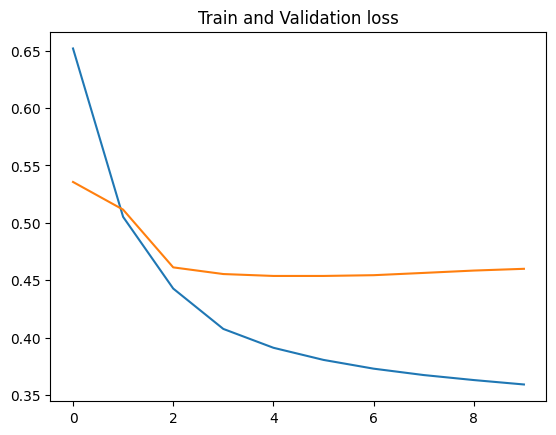

In [63]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Train and Validation loss")
plt.show()

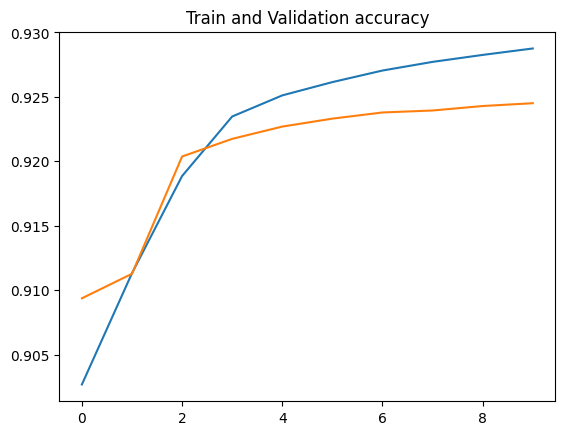

In [64]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Train and Validation accuracy")
plt.show()

In [65]:
# Extract necessary components from the trained model
encoder_inputs = model.input[0]  # Input layer for encoder
decoder_inputs = model.input[1]  # Input layer for decoder
enc_emb_layer = model.get_layer('embedding')  # Embedding layer for encoder
dec_emb_layer = model.get_layer('embedding_1')  # Embedding layer for decoder
encoder_lstm = model.get_layer('lstm')  # LSTM layer for encoder
decoder_lstm = model.get_layer('lstm_1')  # LSTM layer for decoder
decoder_dense = model.get_layer('dense')  # Dense layer for decoder

In [66]:
encoder_model = Model(encoder_inputs, encoder_lstm(enc_emb_layer(encoder_inputs))[1:])

In [67]:
# Define the decoder model for inference
latent_dim = 64  # From the notebook
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [68]:

# Reusing the decoder embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)

# Apply the decoder LSTM with current states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

# Apply the dense layer to get output probabilities
decoder_outputs2 = decoder_dense(decoder_outputs2)


In [79]:
# Define the decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + [state_h2, state_c2]
)

In [70]:
# Translation function
def translate_sentence(sentence, max_len_eng, max_len_fr, eng_tokenizer, fr_tokenizer, encoder_model, decoder_model):
    sentence = process_text(sentence)
    sentence = '<SOS> ' + sentence + ' <EOS>'
    
    seq = eng_tokenizer.texts_to_sequences([sentence])
    seq_padded = pad_sequences(seq, maxlen=max_len_eng, padding='post')
    
    # Encode the input sequence to get initial states
    states_value = encoder_model.predict(seq_padded, verbose=0)
    
    # Initialize decoder input with the start token <SOS>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fr_tokenizer.word_index['<sos>']
    
    # Initialize output sentence
    output_sentence = []
    stop_condition = False
    
    while not stop_condition:
        # Predict the next word and states
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        
        # Get the index of the word with the highest probability
        predicted_index = np.argmax(output_tokens[0, 0, :])
        predicted_word = fr_tokenizer.index_word.get(predicted_index, '')
        
        # Check for end token or maximum length
        if predicted_word == '<eos>' or len(output_sentence) >= max_len_fr:
            stop_condition = True
        else:
            output_sentence.append(predicted_word)
            # Update the target sequence for the next step
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = predicted_index
            # Update the states
            states_value = [h, c]
    
    return ' '.join(output_sentence)


In [72]:
new_sentence = "Hello, how are you?"
translation = translate_sentence(new_sentence, max_len_eng, max_len_fr, eng_tokenizer, fr_tokenizer, encoder_model, decoder_model)
print("English:", new_sentence)
print("French:", translation)

English: Hello, how are you?
French: alut, comment on va ?


In [73]:
# Additional example
another_sentence = "I love to travel."
translation2 = translate_sentence(another_sentence, max_len_eng, max_len_fr, eng_tokenizer, fr_tokenizer, encoder_model, decoder_model)
print("English:", another_sentence)
print("French:", translation2)

English: I love to travel.
French: 'adore le faire.


In [74]:
# Additional example
another_sentence = "The world is not a lovely place."
translation2 = translate_sentence(another_sentence, max_len_eng, max_len_fr, eng_tokenizer, fr_tokenizer, encoder_model, decoder_model)
print("English:", another_sentence)
print("French:", translation2)

English: The world is not a lovely place.
French: e chien a t il dit que tu saches que je suis s r que je ne suis pas s r de vouloir le faire.


In [84]:
import numpy as np
from collections import Counter

def get_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def bleu_score(candidate, references, max_n=4):
    """
    Compute the BLEU score for a candidate translation against a list of reference translations.
    
    Args:
        candidate (str): The machine-generated translation.
        references (list of str): List of reference translations.
        max_n (int): Maximum n-gram length to consider (default is 4).
    
    Returns:
        float: BLEU score between 0 and 1.
    
    Raises:
        ValueError: If no references are provided.
    """
    # Tokenize the candidate and references by splitting on spaces
    candidate_tokens = candidate.split()
    reference_tokens = [ref.split() for ref in references]
    
    # Handle edge cases
    if not references:
        raise ValueError("No references provided")
    if not candidate_tokens:
        return 0.0
    
    # Calculate precision for each n-gram order
    precisions = []
    for n in range(1, max_n + 1):
        if len(candidate_tokens) < n:
            precisions.append(0)
            continue
        
        # Extract n-grams
        candidate_ngrams = get_ngrams(candidate_tokens, n)
        candidate_counter = Counter(candidate_ngrams)
        reference_counters = [Counter(get_ngrams(ref, n)) for ref in reference_tokens if len(ref) >= n]
        
        if not reference_counters:
            precisions.append(0)
            continue
        
        # Compute clipped counts
        clipped_count_sum = 0
        for ngram in candidate_counter:
            max_count = max(ref_counter.get(ngram, 0) for ref_counter in reference_counters)
            clipped_count_sum += min(candidate_counter[ngram], max_count)
        
        total_ngrams = len(candidate_ngrams)
        precision_n = clipped_count_sum / total_ngrams if total_ngrams > 0 else 0
        precisions.append(precision_n)
    
    # Compute geometric mean of precisions
    if all(p > 0 for p in precisions):
        geometric_mean = np.exp(np.mean([np.log(p) for p in precisions]))
    else:
        geometric_mean = 0
    
    # Compute brevity penalty
    candidate_length = len(candidate_tokens)
    reference_lengths = [len(ref) for ref in reference_tokens]
    # Find the reference length closest to candidate length
    differences = [abs(ref_len - candidate_length) for ref_len in reference_lengths]
    min_diff = min(differences)
    r = reference_lengths[differences.index(min_diff)]
    
    if candidate_length > r:
        bp = 1
    else:
        bp = np.exp(1 - r / candidate_length) if candidate_length > 0 else 0
    
    # Final BLEU score
    bleu = bp * geometric_mean
    return bleu

In [ ]:
idx_val = []
for x in X_val:
    idx = np.where((eng_padded == x).all(axis=1))[0]
    if len(idx) == 1:
        idx_val.append(idx[0])
    elif len(idx) > 1:
        print(f"Warning: Duplicate sequence found for {x}, selecting first match")
        idx_val.append(idx[0])  # Select first match
    else:
        print(f"Warning: Sequence not found in eng_padded: {x}")
        continue  # Skip missing sequences

# Extract validation set
if idx_val:  # Ensure idx_val is not empty
    df_val = df.iloc[idx_val]
else:
    raise ValueError("No valid sequences found for validation set")

# Continue with BLEU score computation
bleu_scores = []
for eng_sentence, group in df_val.groupby('English'):
    original_eng = remove_sos_eos(eng_sentence)
    candidate = translate_sentence(
        original_eng, max_len_eng, max_len_fr, 
        eng_tokenizer, fr_tokenizer, encoder_model, decoder_model
    )
    references = [remove_sos_eos(fr) for fr in group['French']]
    score = bleu_score(candidate, references)
    bleu_scores.append(score)

# Calculate and display average BLEU score
average_bleu = np.mean(bleu_scores)
print(f"Average BLEU score: {average_bleu:.4f}")

    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0], selecting first match
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0], selecting first match
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0], selecting first match
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0], selecting first match
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  

Belu score could not be check for accuracy of the transaltion since it causes out of memory error